Categorical Regression on Hawks dataset
Dataset details: dataset contains information about 3 species of hawks (CH=Cooper's, RT=Red-tailed, SS=Sharp-Shinned). This dataset has information for 908 individuals in total, each one containing 16 variables, in addition to the species. 
1. Wing: Length (in mm) of primary wing feather from tip to wrist it attaches to.
2. Weight: Body weight (in gr).
3. Culmen: Length (in mm) of the upper bill from the tip to where it bumps into the fleshy part of the bird.
4. Hallux: Length (in mm) of the killing talon.
5. Tail: Measurement (in mm) related to the length of the tail.


In [1]:
import sys

!{sys.executable} -m pip install pymc-bart

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.6/484.6 KB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 3.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 KB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.2 MB

In [2]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import seaborn as sns

warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
RANDOM_SEED = 8457
az.style.use("arviz-darkgrid") 

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


def load_data(file_path):
    data = pd.read_csv(file_path)
    data = data[['Species', 'Wing', 'Weight', 'Culmen', 'Hallux', 'Tail']]
    return data

def preprocess_data(data):
    # Define the features
    numerical_features = ['Wing', 'Weight', 'Culmen', 'Hallux', 'Tail']
    categorical_features = ['Species']

    # Define transformers for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with mean
        ('scaler', StandardScaler())  # Standardize numerical features
    ])

    # Combine transformers into a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
        ])

    # Separate features and target variable
    X = data[numerical_features]
    y = data['Species']
    y = pd.get_dummies(y, drop_first=True)
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   
    # Apply the preprocessing transformations
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, X_test, y_train, y_test

data = load_data('Datasets/Hawks.csv')
X_train, X_test, y_train, y_test = preprocess_data(data)


/tmp/ipykernel_195590/3032157351.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


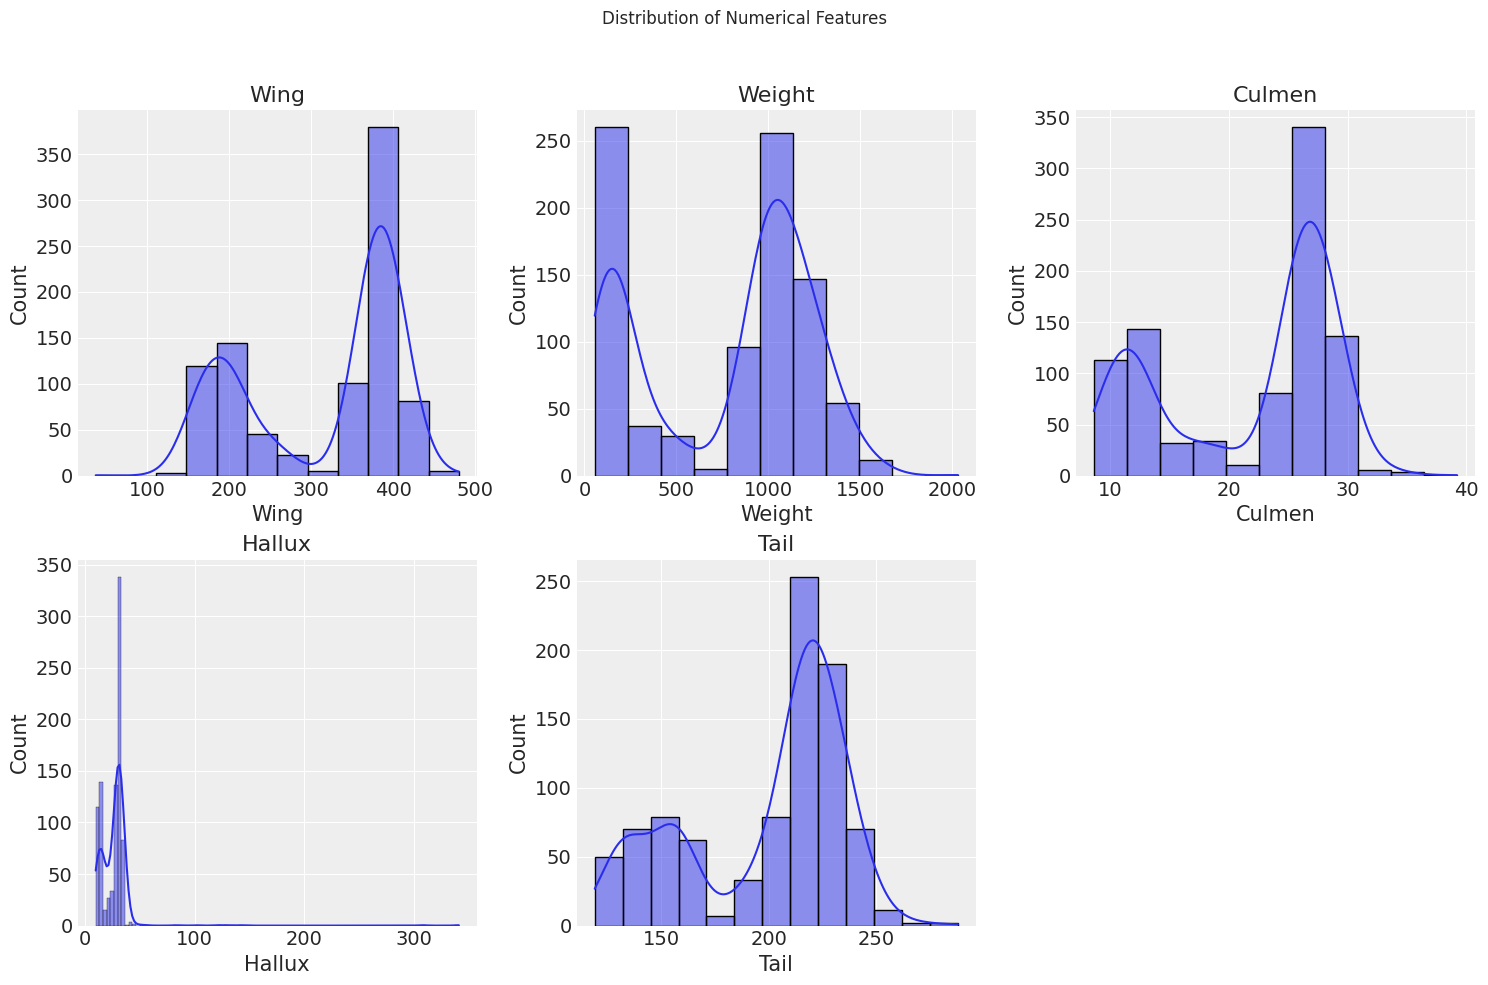

/tmp/ipykernel_195590/3032157351.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


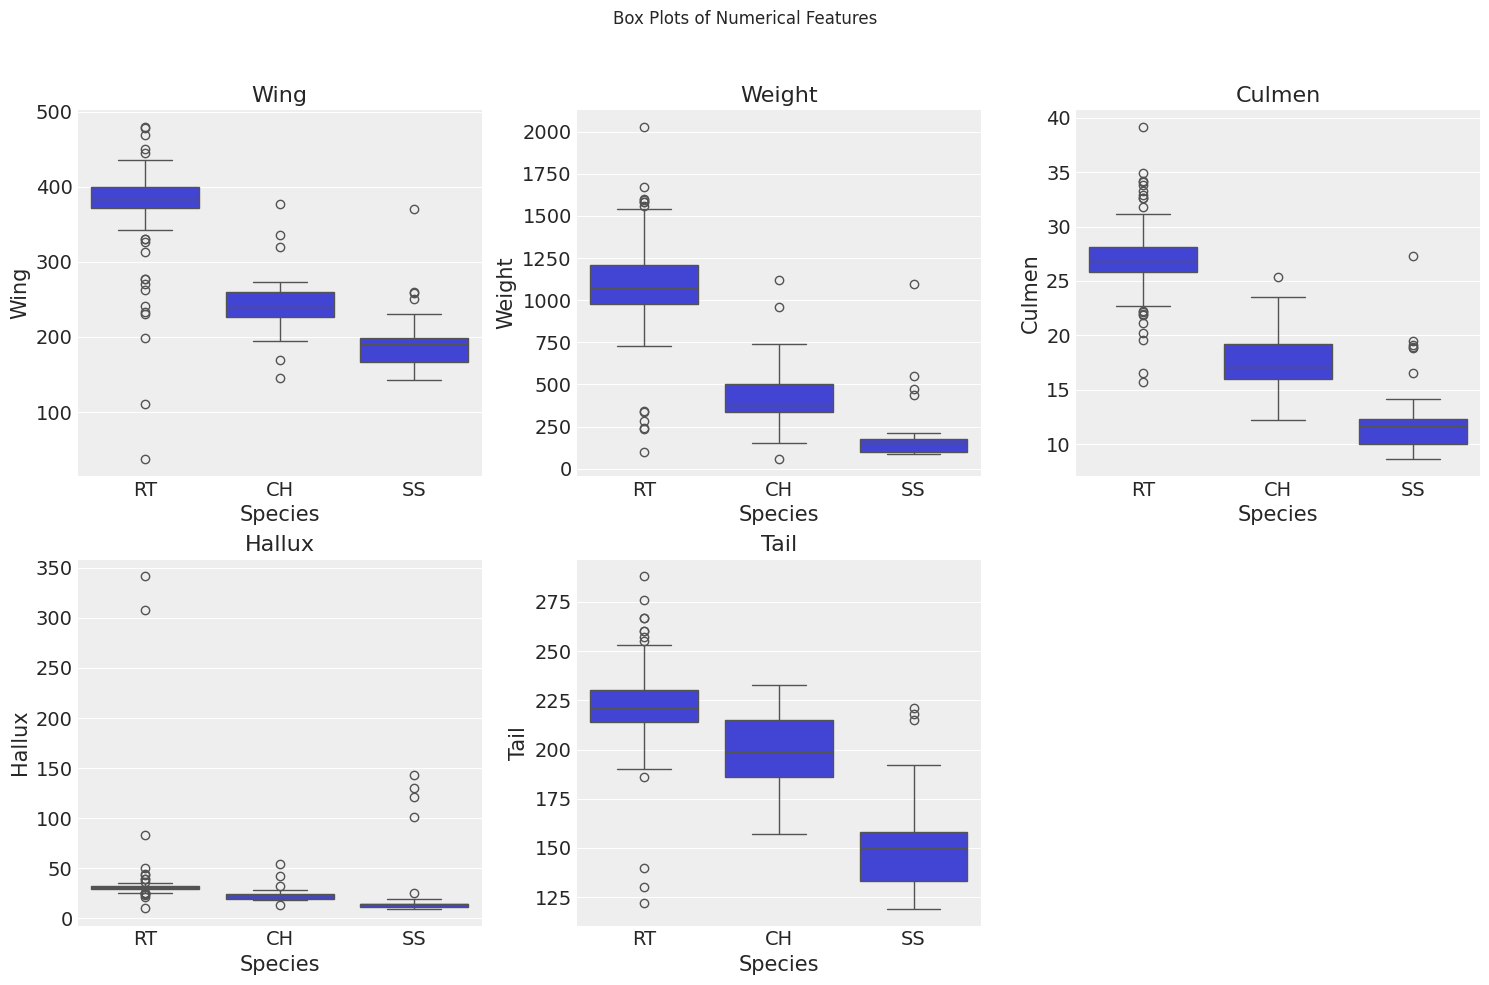

/tmp/ipykernel_195590/3032157351.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


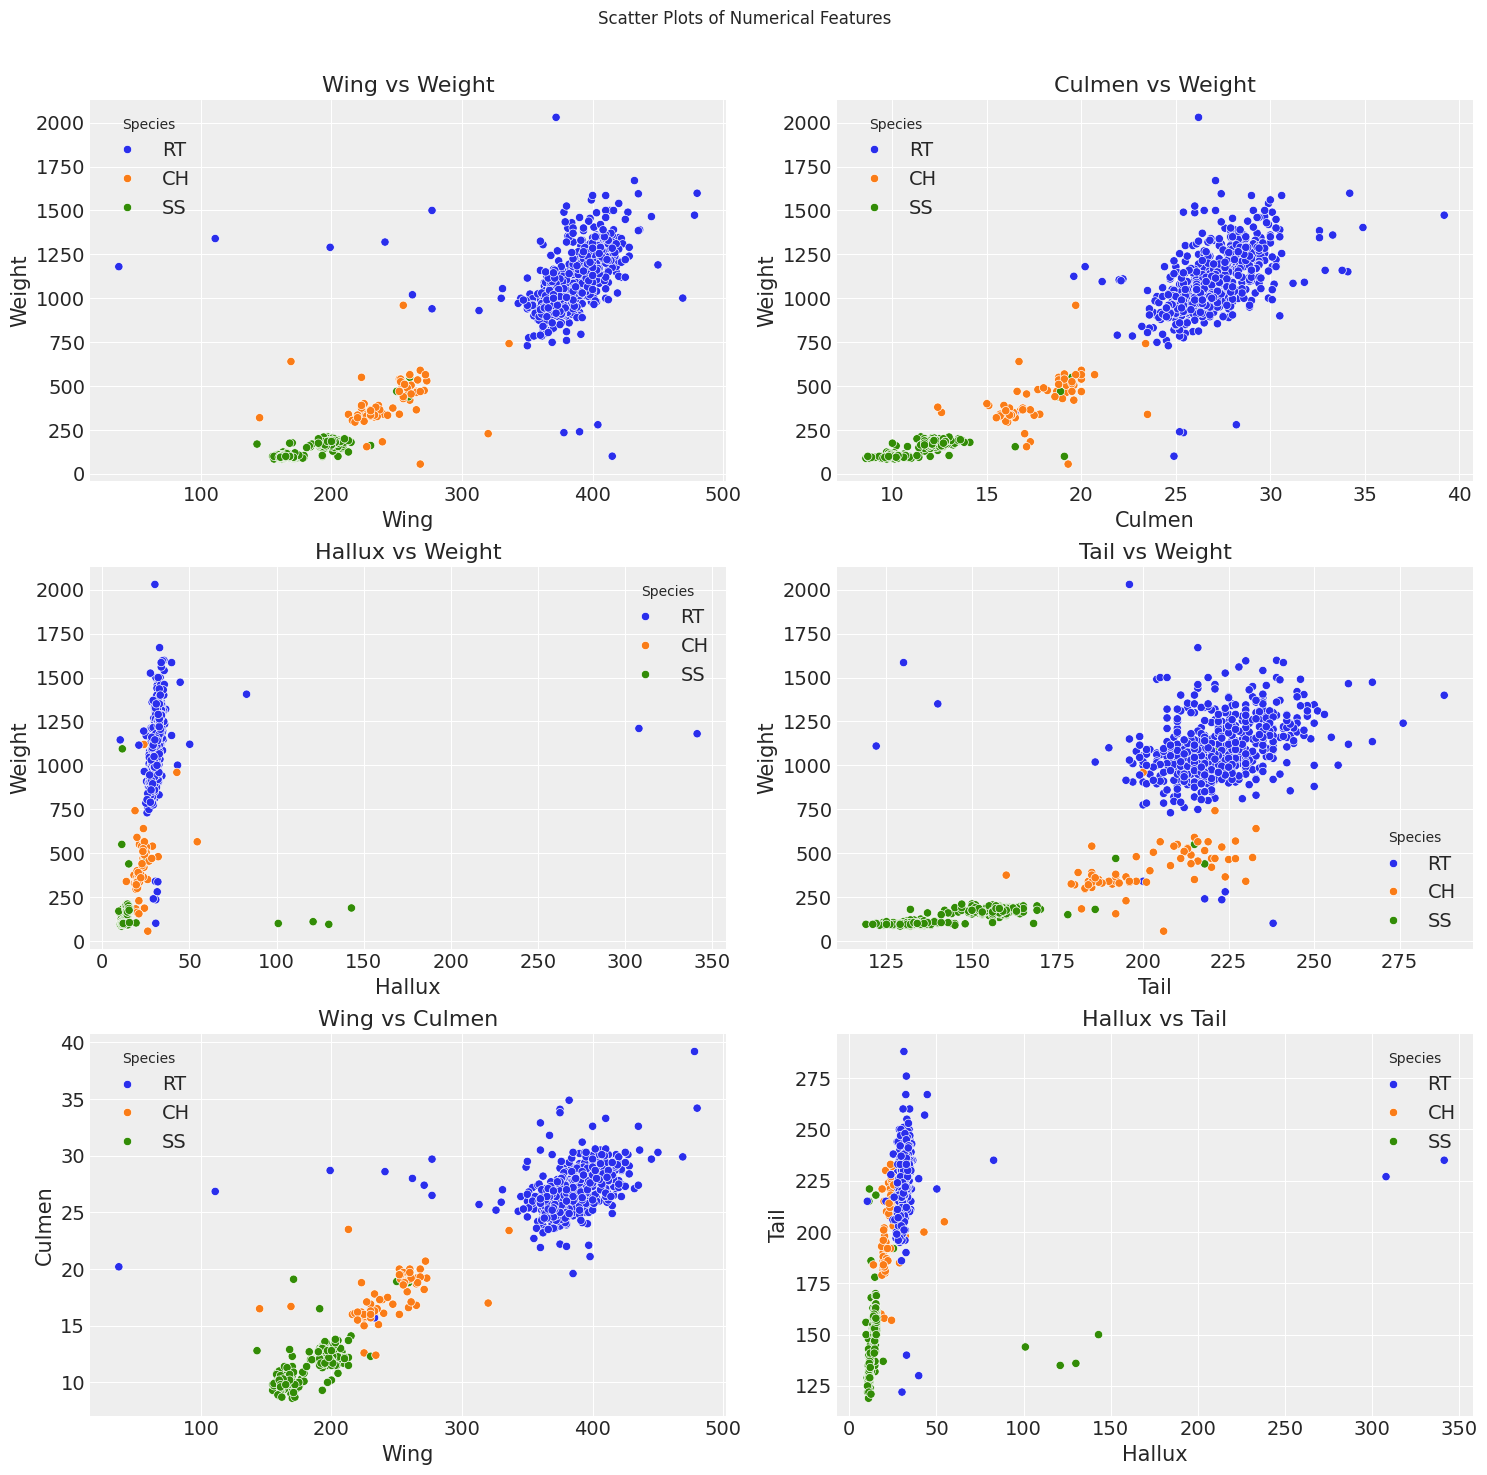

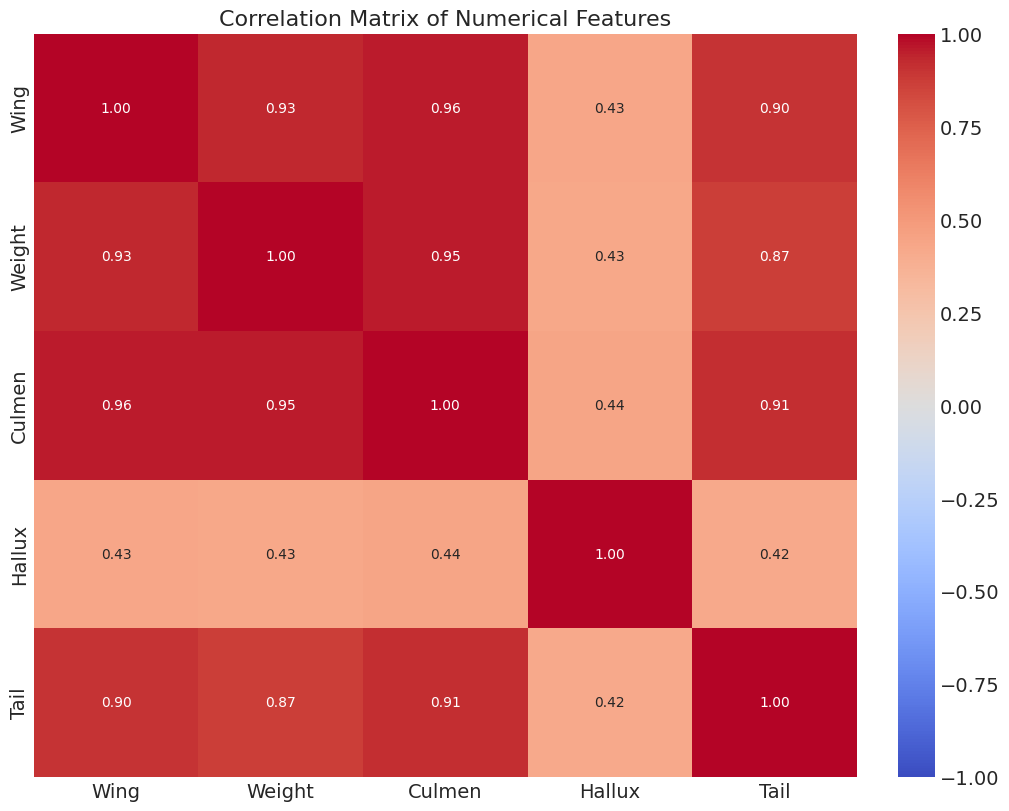

/home/shashidhar/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


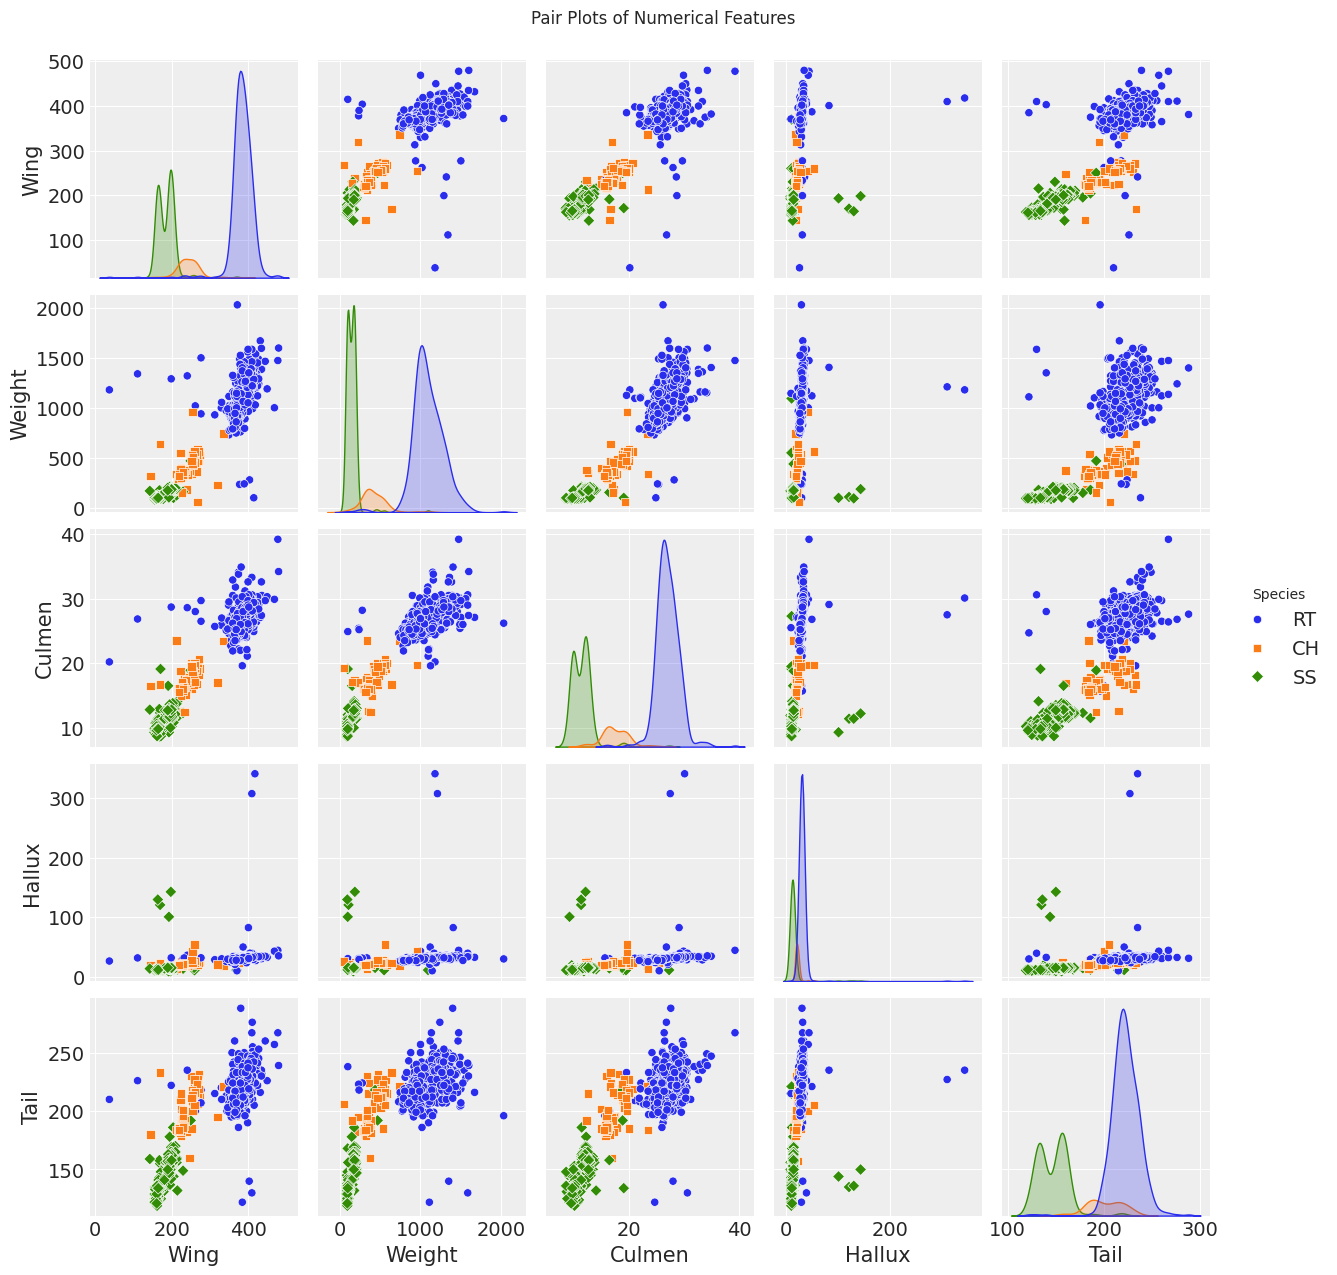

In [34]:
features = ['Wing', 'Weight', 'Culmen', 'Hallux', 'Tail']

def plot_distributions(data):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Distribution of Numerical Features')

    sns.histplot(data['Wing'], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Wing')

    sns.histplot(data['Weight'], kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Weight')

    sns.histplot(data['Culmen'], kde=True, ax=axes[0, 2])
    axes[0, 2].set_title('Culmen')

    sns.histplot(data['Hallux'], kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Hallux')

    sns.histplot(data['Tail'], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Tail')
    fig.delaxes(axes[1, 2])
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

plot_distributions(data)

def plot_boxplots(data):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Box Plots of Numerical Features')

    sns.boxplot(x='Species', y='Wing', data=data, ax=axes[0, 0])
    axes[0, 0].set_title('Wing')

    sns.boxplot(x='Species', y='Weight', data=data, ax=axes[0, 1])
    axes[0, 1].set_title('Weight')

    sns.boxplot(x='Species', y='Culmen', data=data, ax=axes[0, 2])
    axes[0, 2].set_title('Culmen')

    sns.boxplot(x='Species', y='Hallux', data=data, ax=axes[1, 0])
    axes[1, 0].set_title('Hallux')

    sns.boxplot(x='Species', y='Tail', data=data, ax=axes[1, 1])
    axes[1, 1].set_title('Tail')
    fig.delaxes(axes[1, 2])
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

plot_boxplots(data)

def plot_scatterplots(data):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('Scatter Plots of Numerical Features')

    sns.scatterplot(x='Wing', y='Weight', hue='Species', data=data, ax=axes[0, 0])
    axes[0, 0].set_title('Wing vs Weight')

    sns.scatterplot(x='Culmen', y='Weight', hue='Species', data=data, ax=axes[0, 1])
    axes[0, 1].set_title('Culmen vs Weight')

    sns.scatterplot(x='Hallux', y='Weight', hue='Species', data=data, ax=axes[1, 0])
    axes[1, 0].set_title('Hallux vs Weight')

    sns.scatterplot(x='Tail', y='Weight', hue='Species', data=data, ax=axes[1, 1])
    axes[1, 1].set_title('Tail vs Weight')

    sns.scatterplot(x='Wing', y='Culmen', hue='Species', data=data, ax=axes[2, 0])
    axes[2, 0].set_title('Wing vs Culmen')

    sns.scatterplot(x='Hallux', y='Tail', hue='Species', data=data, ax=axes[2, 1])
    axes[2, 1].set_title('Hallux vs Tail')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

plot_scatterplots(data)

def plot_correlation_matrix(data):
    corr = data.drop(columns='Species').corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()



plot_correlation_matrix(data)

def plot_pairplots(data):
    sns.pairplot(data.dropna(), hue='Species', diag_kind='kde', markers=["o", "s", "D"])
    plt.suptitle('Pair Plots of Numerical Features', y=1.02)
    plt.show()

plot_pairplots(data)


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report


def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Support Vector Machine': SVC(kernel='linear')
    }

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f'{model_name} Classification Report:')
        print(classification_report(y_test, y_pred))

train_and_evaluate_models(X_train, X_test, y_train, y_test)


ValueError: y should be a 1d array, got an array of shape (726, 2) instead.

In [37]:
y_train

,RT,SS
84,False,True
10,True,False
617,False,True
250,True,False
869,False,True
...,...,...
106,False,True
270,True,False
860,True,False
435,True,False


/home/shashidhar/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


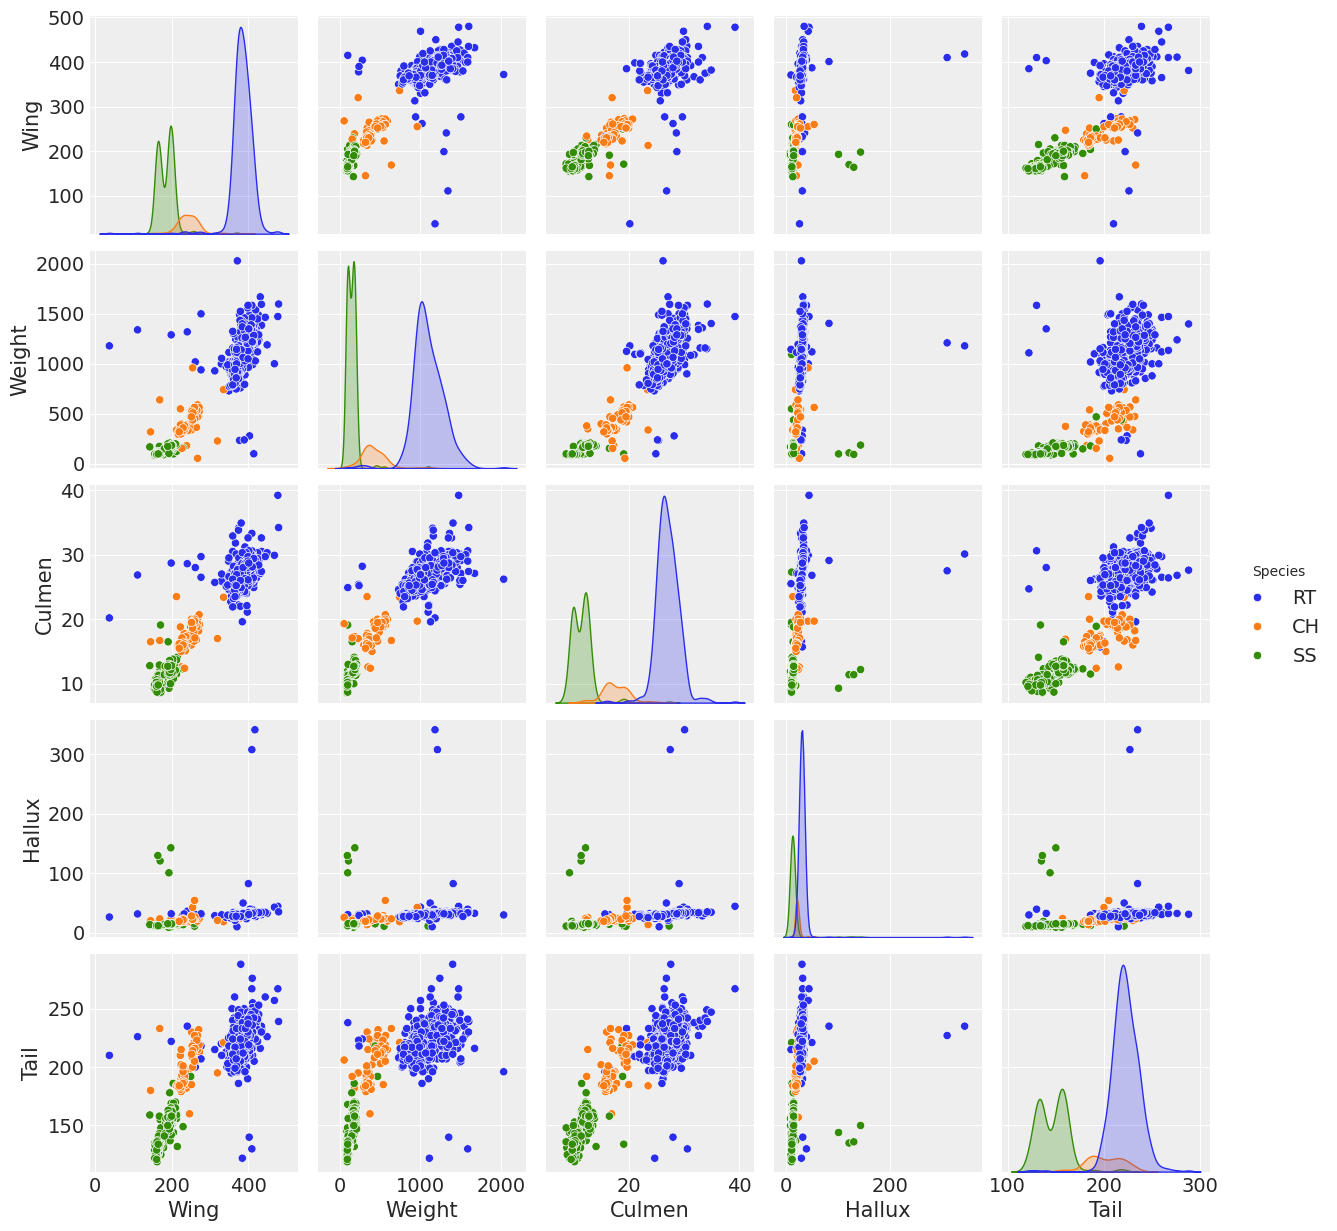

In [5]:
sns.pairplot(Hawks, hue="Species");

891 (891, 5) (891,)
Index(['CH', 'RT', 'SS'], dtype='object')


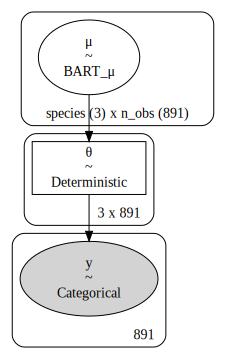

In [6]:
y_0 = pd.Categorical(Hawks["Species"]).codes
x_0 = Hawks[["Wing", "Weight", "Culmen", "Hallux", "Tail"]]
print(len(x_0), x_0.shape, y_0.shape)
_, species = pd.factorize(Hawks["Species"], sort=True)
print(species)
coords = {"n_obs": np.arange(len(x_0)), "species": species}
with pm.Model(coords=coords) as model_hawks:
    μ = pmb.BART("μ", x_0, y_0, m=50, dims=["species", "n_obs"])
    θ = pm.Deterministic("θ", pm.math.softmax(μ, axis=0))
    y = pm.Categorical("y", p=θ.T, observed=y_0)

pm.model_to_graphviz(model=model_hawks)

In [7]:
with model_hawks:
    idata = pm.sample(chains=4, compute_convergence_checks=False, random_seed=123)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)



Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
Sampling: [y]


Output()

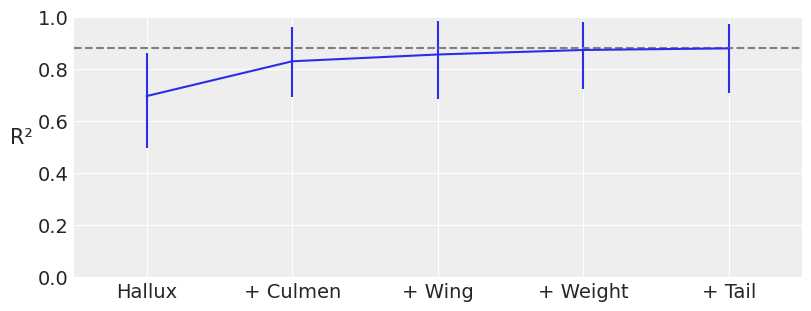

In [8]:
pmb.plot_variable_importance(idata, μ, x_0, method="VI", random_seed=RANDOM_SEED);

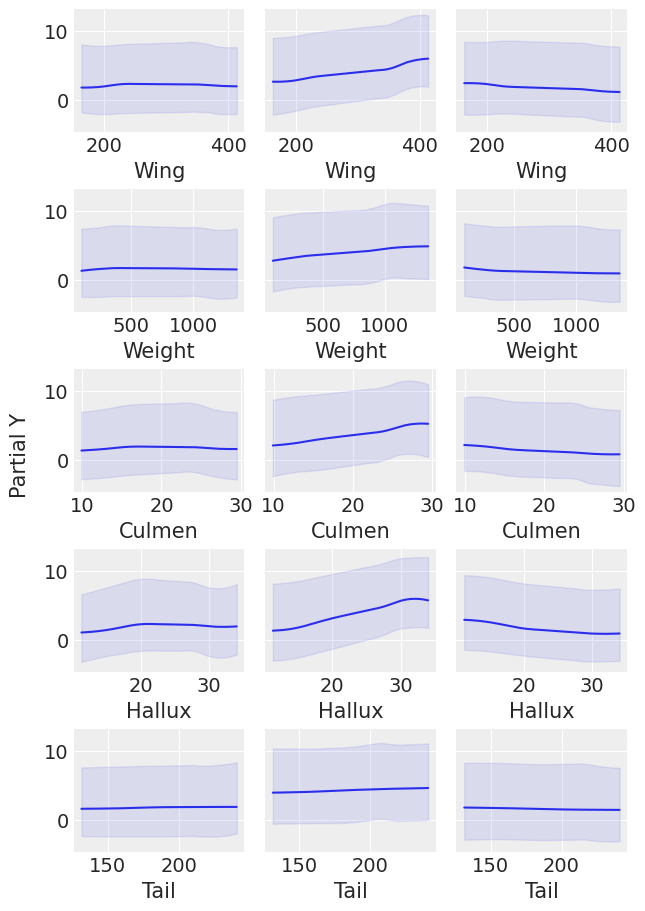

In [9]:
pmb.plot_pdp(μ, X=x_0, Y=y_0, grid=(5, 3), figsize=(6, 9));

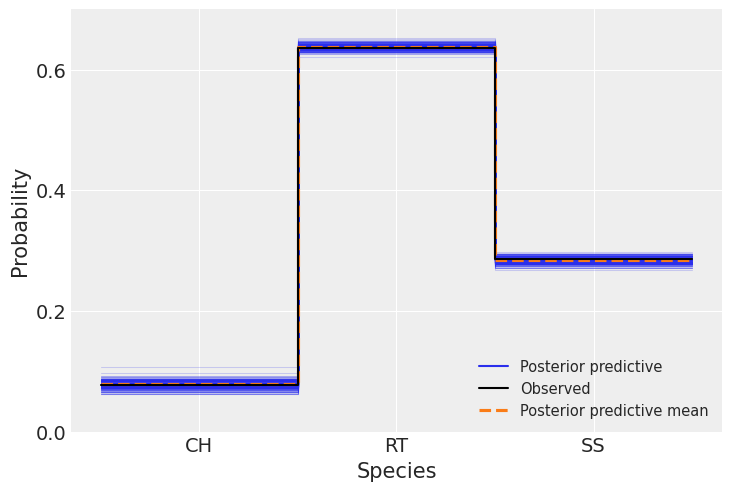

In [10]:
ax = az.plot_ppc(idata, kind="kde", num_pp_samples=200, random_seed=123)
# plot aesthetics
ax.set_ylim(0, 0.7)
ax.set_yticks([0, 0.2, 0.4, 0.6])
ax.set_ylabel("Probability")
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(["CH", "RT", "SS"])
ax.set_xlabel("Species");

In [11]:
np.mean((idata.posterior_predictive["y"] - y_0) == 0) * 100

<xarray.DataArray 'y' ()> Size: 8B
array(95.85491021)

In [12]:
all = 0
for i in range(3):
    perct_per_class = np.mean(idata.posterior_predictive["y"].where(y_0 == i) == i) * 100
    all += perct_per_class
    print(perct_per_class)
all

<xarray.DataArray 'y' ()> Size: 8B
array(5.8506734)
<xarray.DataArray 'y' ()> Size: 8B
array(62.68639169)
<xarray.DataArray 'y' ()> Size: 8B
array(27.31784512)


<xarray.DataArray 'y' ()> Size: 8B
array(95.85491021)

In [13]:
with pm.Model(coords=coords) as model_t:
    μ_t = pmb.BART("μ", x_0, y_0, m=50, separate_trees=True, dims=["species", "n_obs"])
    θ_t = pm.Deterministic("θ", pm.math.softmax(μ_t, axis=0))
    y_t = pm.Categorical("y", p=θ_t.T, observed=y_0)
    idata_t = pm.sample(chains=4, compute_convergence_checks=False, random_seed=123)
    pm.sample_posterior_predictive(idata_t, extend_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 254 seconds.
Sampling: [y]


Output()

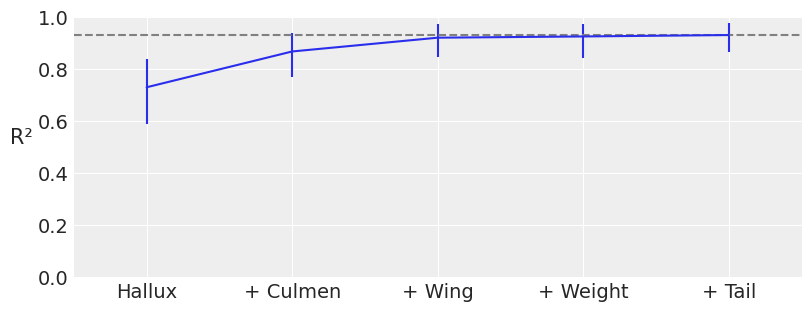

In [14]:
pmb.plot_variable_importance(idata_t, μ_t, x_0, method="VI", random_seed=RANDOM_SEED);

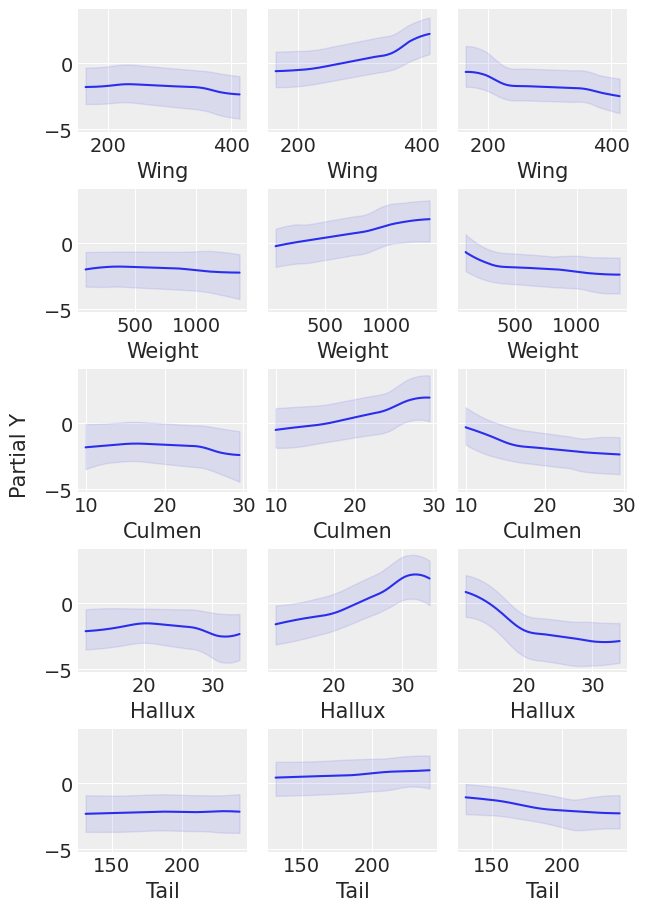

In [15]:
pmb.plot_pdp(μ_t, X=x_0, Y=y_0, grid=(5, 3), figsize=(6, 9));

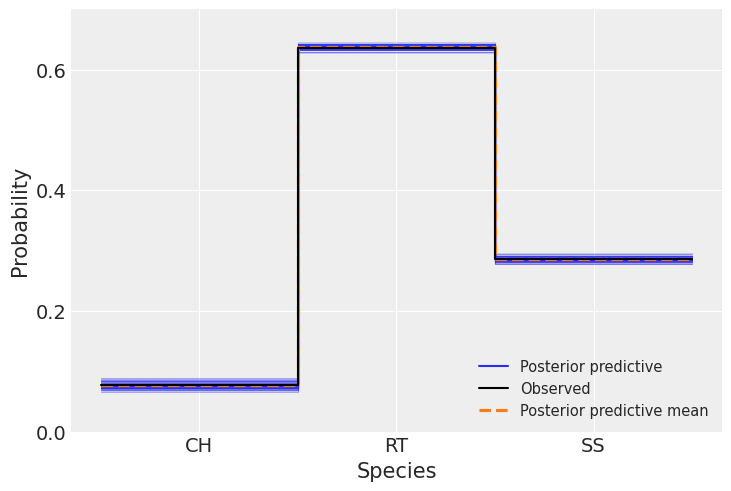

In [16]:
ax = az.plot_ppc(idata_t, kind="kde", num_pp_samples=100, random_seed=123)
ax.set_ylim(0, 0.7)
ax.set_yticks([0, 0.2, 0.4, 0.6])
ax.set_ylabel("Probability")
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(["CH", "RT", "SS"])
ax.set_xlabel("Species");

In [17]:
np.mean((idata_t.posterior_predictive["y"] - y_0) == 0) * 100

<xarray.DataArray 'y' ()> Size: 8B
array(97.19003928)

In [18]:
all = 0
for i in range(3):
    perct_per_class = np.mean(idata_t.posterior_predictive["y"].where(y_0 == i) == i) * 100
    all += perct_per_class
    print(perct_per_class)
all

<xarray.DataArray 'y' ()> Size: 8B
array(6.45106622)
<xarray.DataArray 'y' ()> Size: 8B
array(62.93100449)
<xarray.DataArray 'y' ()> Size: 8B
array(27.80796857)


<xarray.DataArray 'y' ()> Size: 8B
array(97.19003928)